In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
splits_root = r"E:\Skripsi\DEC\dataset\ae-supervised-dataset\splits"
train_csv = os.path.join(splits_root, "train_latent.csv")
test_csv  = os.path.join(splits_root, "test_latent.csv")


train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

In [3]:
y_train = train_df["label"].values
y_test  = test_df["label"].values

X_train = train_df.drop(columns=["filename","label"]).values
X_test  = test_df.drop(columns=["filename","label"]).values

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

Improvement pada Weight tiap kelas, akurasi berkurang dari 74 - 72

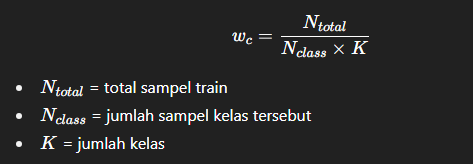

In [14]:
class_counts = np.bincount(y_train_enc)
n_total = len(y_train_enc)
n_classes = len(class_counts)

# Bobot kelas
linear_weights = {i: n_total / (count * n_classes) for i, count in enumerate(class_counts)}
class_weights = {i: min(w, 4.0) for i, w in linear_weights.items()}

print("Class Weights:", class_weights)

# Buat sample_weight sesuai label
sample_weights = np.array([class_weights[label] for label in y_train_enc])


Class Weights: {0: np.float64(3.1518367346938776), 1: np.float64(0.782370820668693), 2: np.float64(0.45964285714285713), 3: np.float64(0.9010501750291715), 4: 4.0}


In [15]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="gpu_hist",   
    eval_metric="mlogloss"
)

model.fit(
    X_train, y_train_enc,
    sample_weight=sample_weights,   
    eval_set=[(X_train, y_train_enc), (X_test, y_test_enc)],
    verbose=True
)

[0]	validation_0-mlogloss:1.55671	validation_1-mlogloss:1.56702
[1]	validation_0-mlogloss:1.50665	validation_1-mlogloss:1.52772


e:\Skripsi\DEC\envTA\lib\site-packages\xgboost\training.py:183: UserWarning: [00:33:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[2]	validation_0-mlogloss:1.45922	validation_1-mlogloss:1.48940
[3]	validation_0-mlogloss:1.41531	validation_1-mlogloss:1.45391
[4]	validation_0-mlogloss:1.37486	validation_1-mlogloss:1.42274
[5]	validation_0-mlogloss:1.33595	validation_1-mlogloss:1.39279
[6]	validation_0-mlogloss:1.29838	validation_1-mlogloss:1.36549
[7]	validation_0-mlogloss:1.26239	validation_1-mlogloss:1.33724
[8]	validation_0-mlogloss:1.22911	validation_1-mlogloss:1.31370
[9]	validation_0-mlogloss:1.19836	validation_1-mlogloss:1.28855
[10]	validation_0-mlogloss:1.16847	validation_1-mlogloss:1.26609
[11]	validation_0-mlogloss:1.14027	validation_1-mlogloss:1.24731
[12]	validation_0-mlogloss:1.11081	validation_1-mlogloss:1.22562
[13]	validation_0-mlogloss:1.08441	validation_1-mlogloss:1.20758
[14]	validation_0-mlogloss:1.06038	validation_1-mlogloss:1.19068
[15]	validation_0-mlogloss:1.03678	validation_1-mlogloss:1.17346
[16]	validation_0-mlogloss:1.01248	validation_1-mlogloss:1.15699
[17]	validation_0-mlogloss:0.9894

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


e:\Skripsi\DEC\envTA\lib\site-packages\xgboost\core.py:2676: UserWarning: [00:33:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:



Classification Report:
              precision    recall  f1-score   support

    GASBURST       0.00      0.00      0.00        61
          MP       0.57      0.69      0.62       247
    ROCKFALL       0.94      0.95      0.95       421
         VTA       0.60      0.65      0.62       214
         VTB       1.00      0.17      0.30        23

    accuracy                           0.74       966
   macro avg       0.62      0.49      0.50       966
weighted avg       0.71      0.74      0.72       966



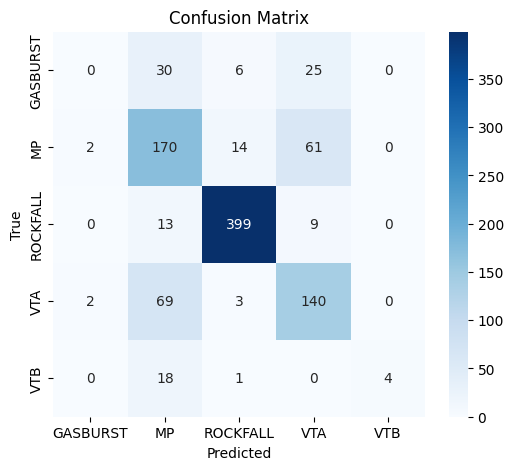

In [16]:
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Penyebab utama

Imbalanced dataset

Kelas minor (misalnya GASBURST) jumlahnya sangat kecil dibanding ROCKFALL atau MP.

XGBoost (seperti model ML lain) akan cenderung “mengabaikan” kelas minor karena tidak mengurangi loss secara signifikan.

Feature overlap

Latent space hasil autoencoder tidak memisahkan GASBURST dengan baik.

Bisa jadi sinyal GASBURST mirip dengan MP/VT, sehingga cluster-nya tidak jelas.

Overfitting pada kelas dominan

Model fokus ke kelas besar (misalnya ROCKFALL) karena jauh lebih sering muncul.

Akibatnya F1 untuk minor classes = 0.